In [1]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps

import random

random.seed(42)

# Baseline Model
# **Two-Branch InceptionV3 Baseline Model (20%L + 80%AB)**

[https://paperswithcode.com/paper/color-aware-two-branch-dcnn-for-efficient](https://paperswithcode.com/paper/color-aware-two-branch-dcnn-for-efficient)


#### Summary
The authors introduced a two-branch deep learning model to classify plant diseases, using the CIE Lab color space instead of the usual RGB. They designed the model with two branches: one to handle the grayscale (L channel) and the other for the color (AB channels). By separating these two types of information, they were able to reduce the number of parameters and the computational load. When tested on the PlantVillage dataset, the model achieved 99.48% accuracy, and on the Cropped-PlantDoc dataset, it reached 76.91% accuracy. Their approach outperformed previous models, showing how this efficient design can lead to better plant disease classification.

We will only be using the Tomato subset from the datasets used in this paper (PlantVillage & PlantDoc)




In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import classification_report
from PIL import Image
import pandas as pd
from tqdm import tqdm
from skimage import color


What the LabTwoBranchDataset class does:-

- Image Conversion: It converts the image from RGB to the Lab color space, which is better for separating color and brightness.

- Normalization: The L and AB channels are scaled to a range of 0 to 1 for easier processing.

- Optional Transformations: It allows you to apply changes (like rotation, resizing) to the L and AB channels if needed.

- Label Mapping: It converts class labels into numbers for easier use in machine learning.

In [3]:
class LabTwoBranchDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform_l=None, transform_ab=None):
        self.data = dataframe
        self.transform_l = transform_l
        self.transform_ab = transform_ab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['filepath']
        img = Image.open(img_path).convert("RGB")
        lab = color.rgb2lab(np.array(img)).astype("float32")
    
        L = lab[:, :, 0]  # shape (H, W)
        ab = lab[:, :, 1:]  # shape (H, W, 2)
    
        if self.transform_l:
            L = self.transform_l(Image.fromarray(L.astype(np.uint8))) 
        else:
            L = torch.from_numpy(L).unsqueeze(0)  # shape (1, H, W)
    
        if self.transform_ab:
            ab = self.transform_ab(Image.fromarray((ab + 128).astype(np.uint8)))  
        else:
            ab = torch.from_numpy(ab).permute(2, 0, 1)  # shape (2, H, W)
    
        label = self.data.iloc[idx]['label']
        return L, ab, label, img_path


This model has two branches that process different types of image information:

1. Luminance (L): One branch handles the grayscale (brightness) part of the image.

2. Chromatic (AB): The other branch handles the color part of the image.

**L Branch**: The first branch applies a convolutional layer, batch normalization, and a ReLU activation function to process the grayscale image.

**AB Branch**: The second branch also applies a convolutional layer, batch normalization, and ReLU activation to process the color information.


- The outputs from both branches (grayscale and color) are merged together to form a combined feature map. 
- The combined features are then passed through an Inception V3 model, which is a popular deep learning architecture used for image classification.
- The final output from the Inception V3 model is passed through a fully connected layer that predicts the class of the image.

This model is designed to handle images that contain both grayscale and color information, processing each type separately before combining them for classification.

In [4]:
class TwoBranchInceptionV3(nn.Module):
    def __init__(self, num_classes, l_filters=20, ab_filters=44):
        super().__init__()
        self.l_branch = nn.Sequential(
            nn.Conv2d(1, l_filters, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(l_filters),
            nn.ReLU(inplace=True),
        )

        self.ab_branch = nn.Sequential(
            nn.Conv2d(2, ab_filters, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(ab_filters),
            nn.ReLU(inplace=True),
        )

        self.merged_channels = l_filters + ab_filters
        self.inception = models.inception_v3(weights=None, aux_logits=False, init_weights=True)
        self.inception.Conv2d_1a_3x3.conv = nn.Conv2d(
            in_channels=self.merged_channels, out_channels=32,
            kernel_size=3, stride=2
        )
        self.inception.fc = nn.Linear(self.inception.fc.in_features, num_classes)

    def forward(self, l, ab):
        x_l = self.l_branch(l)
        x_ab = self.ab_branch(ab)
        x = torch.cat([x_l, x_ab], dim=1)
        return self.inception(x)

## Plant Village 
First we trained and evaluated the model on the [PlantVillage](https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset) dataset

# PlantDoc Dataset

Then we trained and tested the model on the PlantDoc dataset, as was done in the paper.

[PlantDoc](https://github.com/pratikkayal/PlantDoc-Dataset)

In [5]:
# !rmdir --help
!rm -rf /kaggle/working/PlantDoc-Dataset
!git clone https://github.com/pratikkayal/PlantDoc-Dataset.git

Cloning into 'PlantDoc-Dataset'...
remote: Enumerating objects: 2670, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 2670 (delta 22), reused 22 (delta 22), pack-reused 2635 (from 1)
Receiving objects: 100% (2670/2670), 932.92 MiB | 56.71 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Updating files: 100% (2581/2581), done.


In [6]:
import os
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms
from tqdm import tqdm
from skimage import color
from PIL import Image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt



### Loading the dataset

In [8]:
dataset_path = '/kaggle/working/PlantDoc-Dataset/'

def load_image_paths_and_labels(dataset_path):
    image_paths = []
    labels = []
    label_dict = {}  
    label_idx = 0
    class_counts = {}  
    class_samples = {}  
    
    for root, dirs, files in os.walk(dataset_path):
        if 'train' in root or 'test' in root:
            for folder in dirs:
                if folder.startswith('Tomato'):  # Only include folders starting with 'Tomato'
                    for file in os.listdir(os.path.join(root, folder)):
                        if file.endswith(('.jpg', '.png')):
                            image_path = os.path.join(root, folder, file)
                            label = folder
                            if label not in label_dict:
                                label_dict[label] = label_idx
                                label_idx += 1
                            image_paths.append(image_path)
                            labels.append(label_dict[label])
                            
                            if label not in class_counts:
                                class_counts[label] = 0
                            class_counts[label] += 1

                            if label not in class_samples:
                                class_samples[label] = []
                            if len(class_samples[label]) < 3:
                                class_samples[label].append(image_path)
    
    return pd.DataFrame({'filepath': image_paths, 'label': labels}), label_dict, class_counts, class_samples

In [9]:
train_df, label_dict, train_class_counts, train_class_samples = load_image_paths_and_labels(os.path.join(dataset_path, 'train'))
test_df, _, test_class_counts, test_class_samples = load_image_paths_and_labels(os.path.join(dataset_path, 'test'))

In [10]:
print("Number of images per class in the training set:")
for label, count in train_class_counts.items():
    print(f"{label}: {count} images")

print("\nNumber of images per class in the testing set:")
for label, count in test_class_counts.items():
    print(f"{label}: {count} images")

Number of images per class in the training set:
Tomato Septoria leaf spot: 140 images
Tomato leaf: 55 images
Tomato two spotted spider mites leaf: 2 images
Tomato leaf bacterial spot: 101 images
Tomato leaf mosaic virus: 44 images
Tomato leaf late blight: 101 images
Tomato mold leaf: 85 images
Tomato Early blight leaf: 79 images
Tomato leaf yellow virus: 70 images

Number of images per class in the testing set:
Tomato Septoria leaf spot: 11 images
Tomato leaf: 8 images
Tomato leaf bacterial spot: 9 images
Tomato leaf mosaic virus: 10 images
Tomato leaf late blight: 10 images
Tomato mold leaf: 6 images
Tomato Early blight leaf: 9 images
Tomato leaf yellow virus: 6 images


### Sample Images


Sample images from class: Tomato Septoria leaf spot


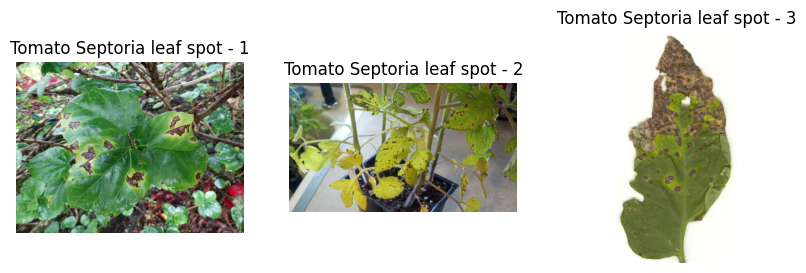


Sample images from class: Tomato leaf


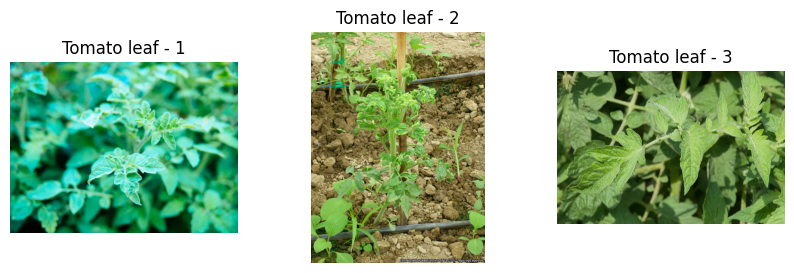


Sample images from class: Tomato two spotted spider mites leaf


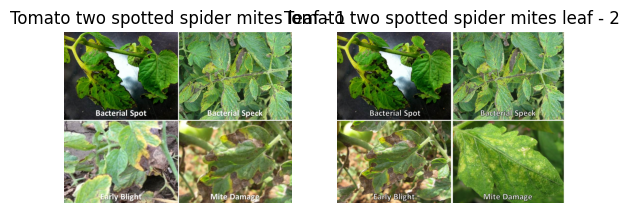


Sample images from class: Tomato leaf bacterial spot


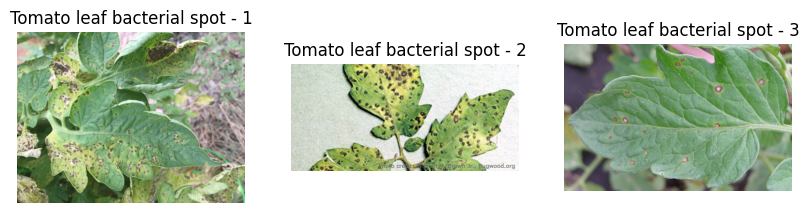


Sample images from class: Tomato leaf mosaic virus


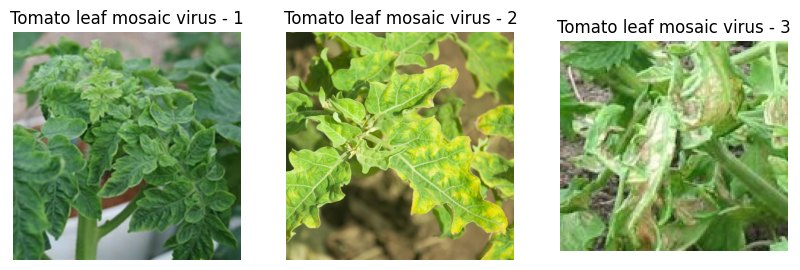


Sample images from class: Tomato leaf late blight


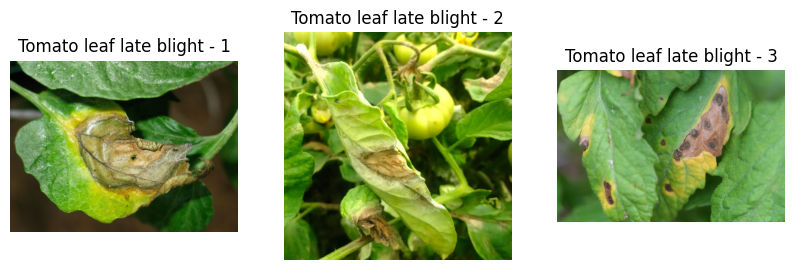


Sample images from class: Tomato mold leaf


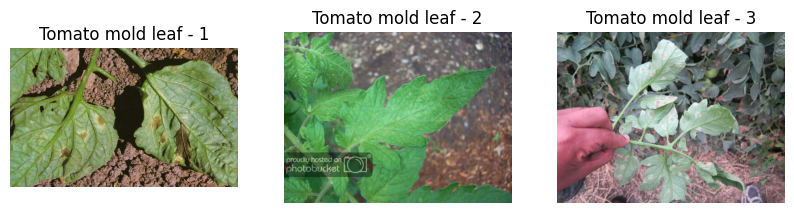


Sample images from class: Tomato Early blight leaf


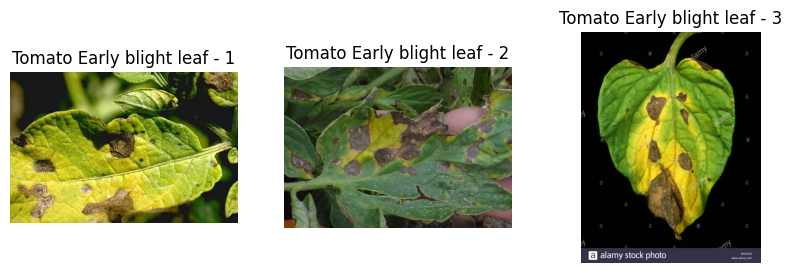


Sample images from class: Tomato leaf yellow virus


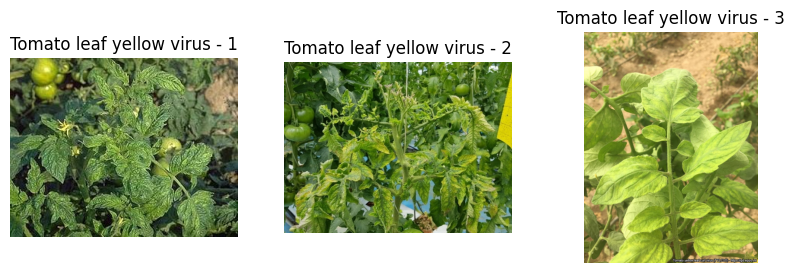


Sample images from class: Tomato Septoria leaf spot


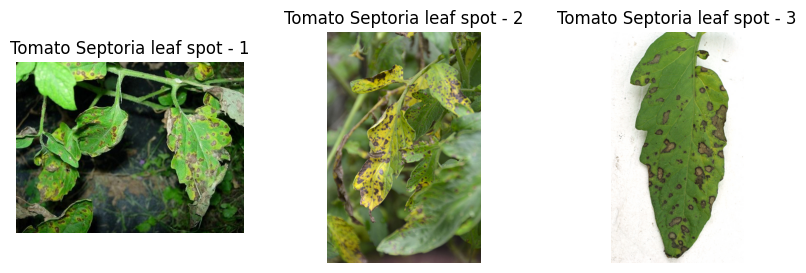


Sample images from class: Tomato leaf


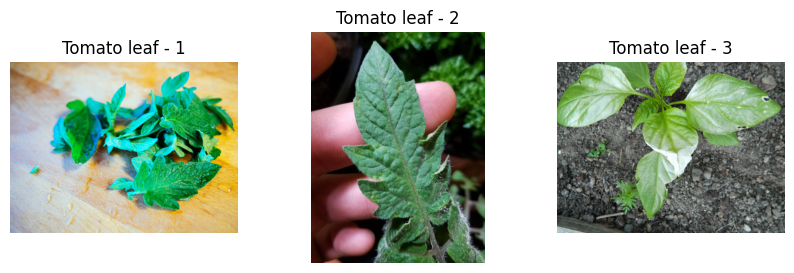


Sample images from class: Tomato leaf bacterial spot


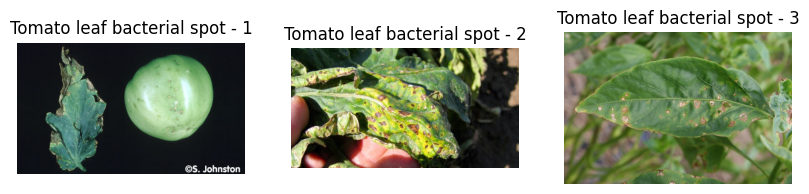


Sample images from class: Tomato leaf mosaic virus


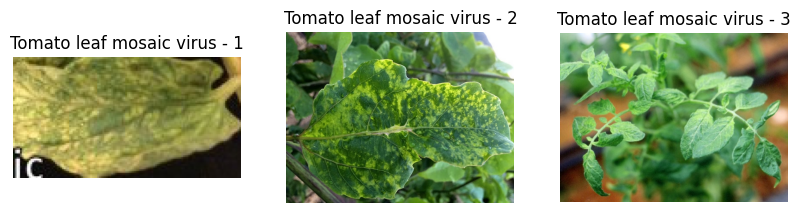


Sample images from class: Tomato leaf late blight


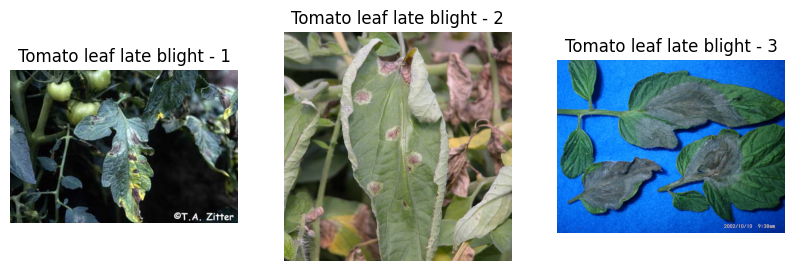


Sample images from class: Tomato mold leaf


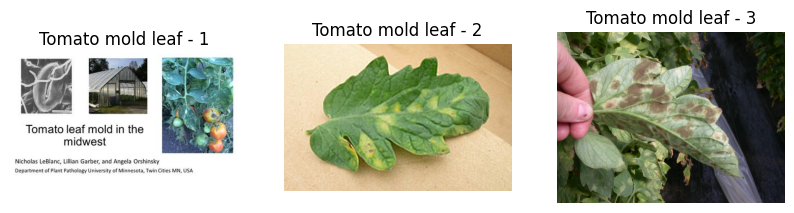


Sample images from class: Tomato Early blight leaf


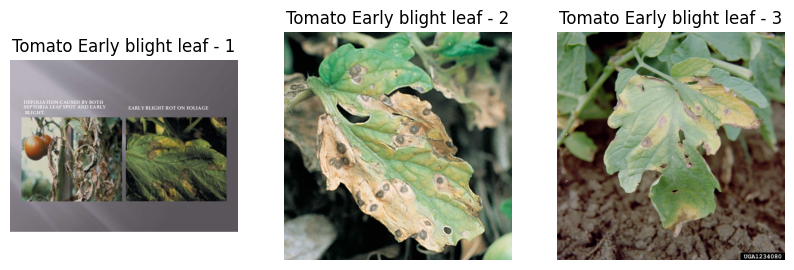


Sample images from class: Tomato leaf yellow virus


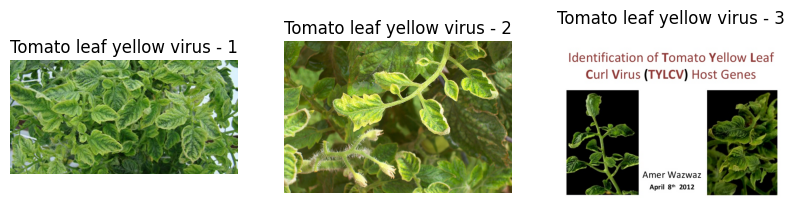

In [11]:
def show_sample_images(class_samples):
    for label, samples in class_samples.items():
        print(f"\nSample images from class: {label}")
        plt.figure(figsize=(10, 3))
        for i, img_path in enumerate(samples):
            img = Image.open(img_path)
            plt.subplot(1, 3, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{label} - {i+1}")
        plt.show()

# Show samples for both training and testing set
show_sample_images(train_class_samples)
show_sample_images(test_class_samples)

## Train-Test Split
The original test set provided in PlantDoc was too small. So we merged both the train and test sets together, and created a new 80-20 split for our use

In [12]:
import os
import torch
import shutil
import random
import pandas as pd
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from skimage import color
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import classification_report
import random

random.seed(42)

dataset_path = 'PlantDoc-Dataset/'

def merge_train_test_folders(dataset_path, exclude_class="Tomato two spotted spider mites leaf"):
    merged_dataset_path = os.path.join(dataset_path, 'merged')
    if not os.path.exists(merged_dataset_path):
        os.makedirs(merged_dataset_path)
    
    for folder in os.listdir(os.path.join(dataset_path, 'train')):
        if folder.startswith('Tomato') and folder != exclude_class:  
            class_folder = os.path.join(merged_dataset_path, folder)
            if not os.path.exists(class_folder):
                os.makedirs(class_folder)
            
            train_class_folder = os.path.join(dataset_path, 'train', folder)
            for file in os.listdir(train_class_folder):
                if file.endswith(('.jpg', '.png')):
                    shutil.move(os.path.join(train_class_folder, file), os.path.join(class_folder, file))

            test_class_folder = os.path.join(dataset_path, 'test', folder)
            for file in os.listdir(test_class_folder):
                if file.endswith(('.jpg', '.png')):
                    shutil.move(os.path.join(test_class_folder, file), os.path.join(class_folder, file))
    
    print("Data merged successfully into the 'merged' folder, excluding the unwanted class.")

merge_train_test_folders(dataset_path)

Data merged successfully into the 'merged' folder, excluding the unwanted class.


In [13]:
def create_train_test_split(merged_dataset_path, exclude_class="Tomato two spotted spider mites leaf", split_ratio=0.8):
    train_image_paths = []
    train_labels = []
    test_image_paths = []
    test_labels = []
    label_dict = {}
    label_idx = 0
    
    for folder in os.listdir(merged_dataset_path):
        if folder.startswith('Tomato') and folder != exclude_class:  
            class_folder = os.path.join(merged_dataset_path, folder)
            images = [os.path.join(class_folder, file) for file in os.listdir(class_folder) if file.endswith(('.jpg', '.png'))]
            
            train_images, test_images = train_test_split(images, train_size=split_ratio, random_state=42)

            if folder not in label_dict:
                label_dict[folder] = label_idx
                label_idx += 1
            
            for img in train_images:
                train_image_paths.append(img)
                train_labels.append(label_dict[folder])
            for img in test_images:
                test_image_paths.append(img)
                test_labels.append(label_dict[folder])
    
    train_df = pd.DataFrame({'filepath': train_image_paths, 'label': train_labels})
    test_df = pd.DataFrame({'filepath': test_image_paths, 'label': test_labels})
    return train_df, test_df, label_dict


In [14]:
merged_dataset_path = os.path.join(dataset_path, 'merged')
train_df, test_df, label_dict = create_train_test_split(merged_dataset_path)
 

print("Number of images per class after merge and split (Train):")
class_counts = train_df['label'].value_counts()
for label, count in class_counts.items():
    class_name = list(label_dict.keys())[list(label_dict.values()).index(label)]
    print(f"{class_name}: {count} images")

print("\n")
print("Number of images per class after merge and split (Test):")
class_counts = test_df['label'].value_counts()
for label, count in class_counts.items():
    class_name = list(label_dict.keys())[list(label_dict.values()).index(label)]
    print(f"{class_name}: {count} images")


Number of images per class after merge and split (Train):
Tomato Septoria leaf spot: 120 images
Tomato leaf bacterial spot: 88 images
Tomato leaf late blight: 88 images
Tomato mold leaf: 72 images
Tomato Early blight leaf: 70 images
Tomato leaf yellow virus: 60 images
Tomato leaf: 50 images
Tomato leaf mosaic virus: 43 images


Number of images per class after merge and split (Test):
Tomato Septoria leaf spot: 30 images
Tomato leaf late blight: 23 images
Tomato leaf bacterial spot: 22 images
Tomato mold leaf: 19 images
Tomato Early blight leaf: 18 images
Tomato leaf yellow virus: 15 images
Tomato leaf: 13 images
Tomato leaf mosaic virus: 11 images


### Model Declaration

In [15]:

# Define transforms
transform_l = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

transform_ab = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

# Create datasets
train_dataset = LabTwoBranchDataset(train_df, transform_l, transform_ab)
test_dataset = LabTwoBranchDataset(test_df, transform_l, transform_ab)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used: {device}")
model = TwoBranchInceptionV3(num_classes=len(label_dict)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Device used: cuda


## Training Loop

In [16]:

train_losses = []
train_accuracies = []

for epoch in range(30):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for l, ab, labels, _ in tqdm(train_loader):
        l, ab, labels = l.to(device), ab.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(l, ab)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")


100%|██████████| 19/19 [01:12<00:00,  3.80s/it]


Epoch 1 - Loss: 2.2351 - Accuracy: 0.1489


100%|██████████| 19/19 [01:16<00:00,  4.02s/it]


Epoch 2 - Loss: 1.9635 - Accuracy: 0.2707


100%|██████████| 19/19 [01:17<00:00,  4.10s/it]


Epoch 3 - Loss: 1.9298 - Accuracy: 0.3096


100%|██████████| 19/19 [01:15<00:00,  3.96s/it]


Epoch 4 - Loss: 1.8281 - Accuracy: 0.3350


100%|██████████| 19/19 [01:13<00:00,  3.87s/it]


Epoch 5 - Loss: 1.7661 - Accuracy: 0.3164


100%|██████████| 19/19 [01:13<00:00,  3.87s/it]


Epoch 6 - Loss: 1.7738 - Accuracy: 0.3553


100%|██████████| 19/19 [01:14<00:00,  3.93s/it]


Epoch 7 - Loss: 1.7480 - Accuracy: 0.3824


100%|██████████| 19/19 [01:20<00:00,  4.23s/it]


Epoch 8 - Loss: 1.6437 - Accuracy: 0.4061


100%|██████████| 19/19 [01:23<00:00,  4.42s/it]


Epoch 9 - Loss: 1.6432 - Accuracy: 0.3993


100%|██████████| 19/19 [01:17<00:00,  4.06s/it]


Epoch 10 - Loss: 1.5059 - Accuracy: 0.4450


100%|██████████| 19/19 [01:13<00:00,  3.85s/it]


Epoch 11 - Loss: 1.5050 - Accuracy: 0.4569


100%|██████████| 19/19 [01:12<00:00,  3.81s/it]


Epoch 12 - Loss: 1.5217 - Accuracy: 0.4399


100%|██████████| 19/19 [01:13<00:00,  3.85s/it]


Epoch 13 - Loss: 1.4486 - Accuracy: 0.4890


100%|██████████| 19/19 [01:20<00:00,  4.26s/it]


Epoch 14 - Loss: 1.3118 - Accuracy: 0.5313


100%|██████████| 19/19 [01:18<00:00,  4.13s/it]


Epoch 15 - Loss: 1.3089 - Accuracy: 0.5110


100%|██████████| 19/19 [01:26<00:00,  4.55s/it]


Epoch 16 - Loss: 1.2373 - Accuracy: 0.5499


100%|██████████| 19/19 [01:25<00:00,  4.48s/it]


Epoch 17 - Loss: 1.2779 - Accuracy: 0.5533


100%|██████████| 19/19 [01:25<00:00,  4.50s/it]


Epoch 18 - Loss: 1.0520 - Accuracy: 0.6277


100%|██████████| 19/19 [01:23<00:00,  4.40s/it]


Epoch 19 - Loss: 1.1441 - Accuracy: 0.5838


100%|██████████| 19/19 [01:25<00:00,  4.52s/it]


Epoch 20 - Loss: 1.2047 - Accuracy: 0.5888


100%|██████████| 19/19 [01:21<00:00,  4.26s/it]


Epoch 21 - Loss: 1.0233 - Accuracy: 0.6464


100%|██████████| 19/19 [01:18<00:00,  4.13s/it]


Epoch 22 - Loss: 0.8734 - Accuracy: 0.7090


100%|██████████| 19/19 [01:16<00:00,  4.04s/it]


Epoch 23 - Loss: 0.9338 - Accuracy: 0.6836


100%|██████████| 19/19 [01:19<00:00,  4.16s/it]


Epoch 24 - Loss: 0.8128 - Accuracy: 0.7107


100%|██████████| 19/19 [01:21<00:00,  4.28s/it]


Epoch 25 - Loss: 0.8706 - Accuracy: 0.6988


100%|██████████| 19/19 [01:28<00:00,  4.68s/it]


Epoch 26 - Loss: 0.7975 - Accuracy: 0.7107


100%|██████████| 19/19 [01:18<00:00,  4.13s/it]


Epoch 27 - Loss: 0.9085 - Accuracy: 0.6836


100%|██████████| 19/19 [01:22<00:00,  4.33s/it]


Epoch 28 - Loss: 0.7692 - Accuracy: 0.7496


100%|██████████| 19/19 [01:13<00:00,  3.85s/it]


Epoch 29 - Loss: 0.6596 - Accuracy: 0.7766


100%|██████████| 19/19 [01:14<00:00,  3.92s/it]

Epoch 30 - Loss: 0.5405 - Accuracy: 0.8020


### Training Loss and Accuracy

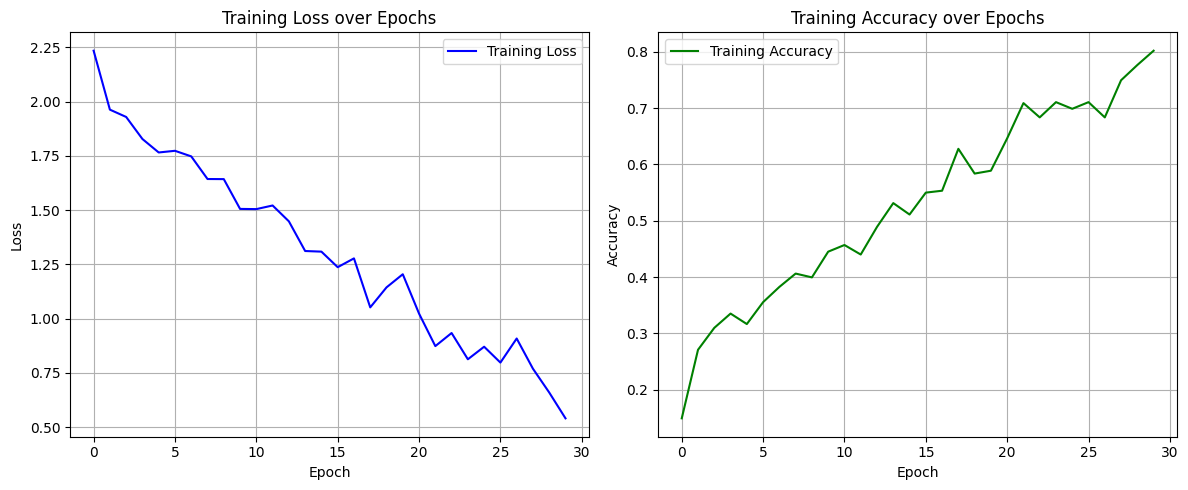

In [17]:
# Plotting
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## Evaluation Results

In [20]:
import matplotlib.pyplot as plt

model.eval()
all_preds, all_labels = [], []
misclassified = []

with torch.no_grad():
    for l, ab, labels, paths in tqdm(test_loader): 
        l, ab = l.to(device), ab.to(device)
        outputs = model(l, ab)
        _, preds = torch.max(outputs, 1)

        preds_np = preds.cpu().numpy()
        labels_np = labels.numpy()

        all_preds.extend(preds_np)
        all_labels.extend(labels_np)

        # Track misclassified examples
        for i in range(len(preds_np)):
            if preds_np[i] != labels_np[i]:
                misclassified.append((paths[i], preds_np[i], labels_np[i]))

accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"\nAccuracy on the test set: {accuracy * 100:.2f}%")

print("\nClassification Report on Test Set:")
print(classification_report(all_labels, all_preds, target_names=list(label_dict.keys())))
print("✅ Testing complete.")


100%|██████████| 5/5 [00:21<00:00,  4.34s/it]


Accuracy on the test set: 33.11%

Classification Report on Test Set:
                            precision    recall  f1-score   support

 Tomato Septoria leaf spot       0.38      0.33      0.36        30
               Tomato leaf       0.36      0.31      0.33        13
Tomato leaf bacterial spot       0.24      0.32      0.27        22
  Tomato leaf mosaic virus       0.04      0.09      0.06        11
   Tomato leaf late blight       0.52      0.65      0.58        23
          Tomato mold leaf       0.27      0.21      0.24        19
  Tomato Early blight leaf       0.42      0.28      0.33        18
  Tomato leaf yellow virus       0.67      0.27      0.38        15

                  accuracy                           0.33       151
                 macro avg       0.36      0.31      0.32       151
              weighted avg       0.37      0.33      0.34       151

✅ Testing complete.


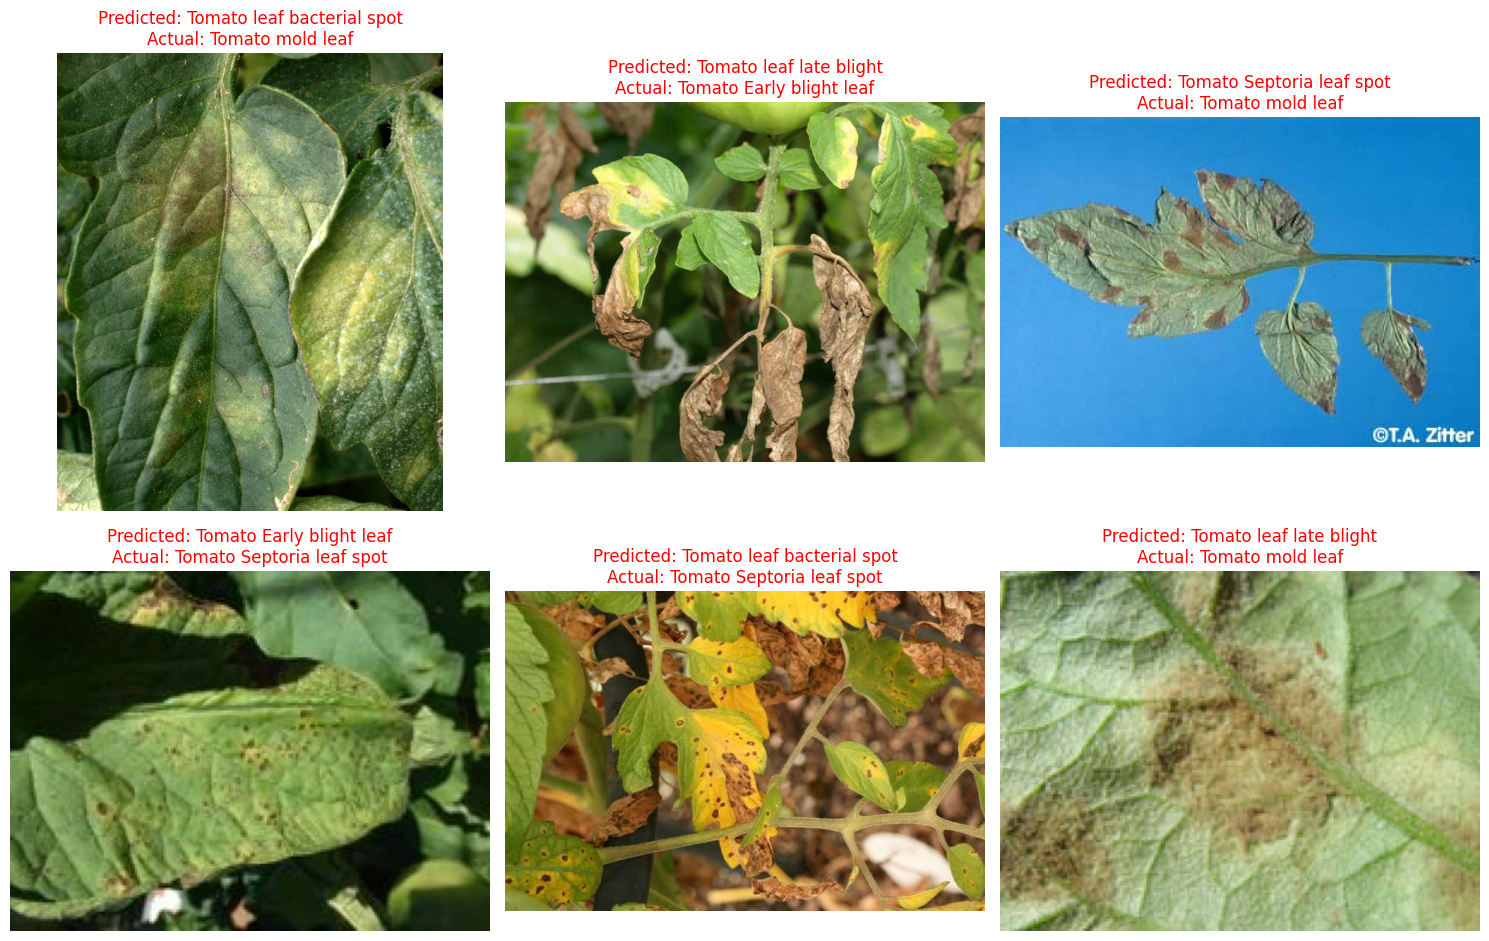

In [19]:
# Show up to 6 misclassified images
num_to_show = min(6, len(misclassified))
plt.figure(figsize=(15, 10))

for idx in range(num_to_show):
    path, pred_idx, true_idx = misclassified[idx]
    img = Image.open(path).convert("RGB")

    plt.subplot(2, 3, idx + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {list(label_dict.keys())[pred_idx]}\nActual: {list(label_dict.keys())[true_idx]}", color="red")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Test Accuracy: 33.11%